In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from stft import *

In [2]:
stft = STFT(step_rate=1)
sound = SoundData()

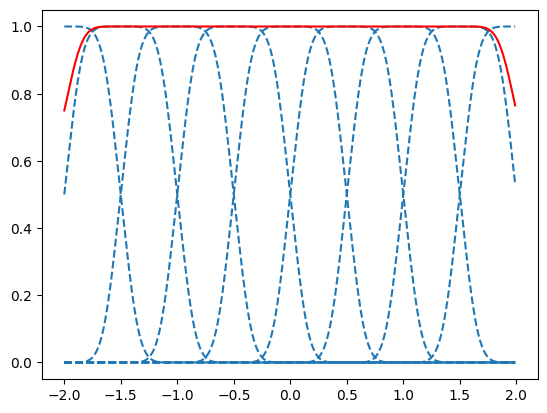

In [3]:
dx=0.01
lim = 2
xrange = np.arange(-lim,lim,dx)
ndiv = 2
irange = range(-int(ndiv*lim),int(ndiv*lim+1))
Ws = np.array([ [stft_default_window(x-i/ndiv) for x in xrange] for i in irange])
for W in Ws:
    plt.plot(xrange, W, '--', color='tab:blue')
plt.plot(xrange, np.sum(Ws, axis=0)/ndiv, '-', color='red') 
plt.show()


In [4]:
tmax = 1 #sec
nu = 201.8 #Hz
A = 1
trange = stft.range(0,tmax)
data = A*np.cos(2*np.pi*nu*trange)
stft(data)

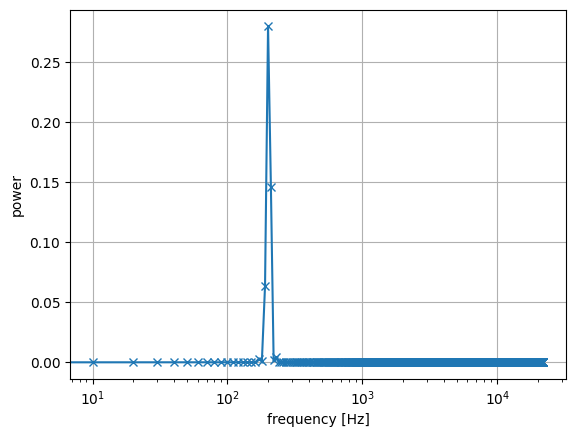

In [5]:
fig, ax = stft.plot_spectrum(0.5, 'x-', view='power')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('power')
ax.grid(True)
plt.show()

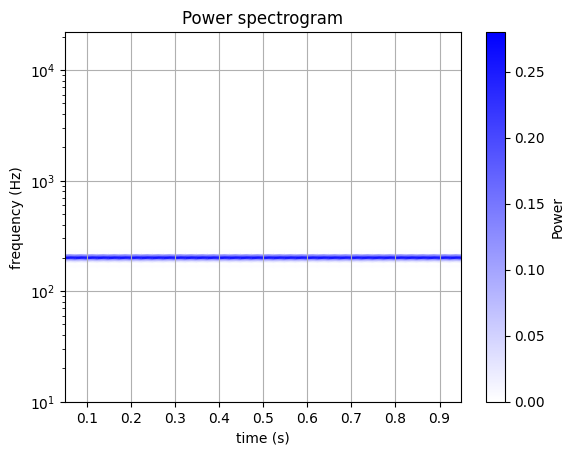

In [6]:
fig,ax,mesh = stft.plot()
ax.set_title('Power spectrogram')
ax.grid(True)
fig.colorbar(mesh, ax=ax, label='Power')
plt.show()

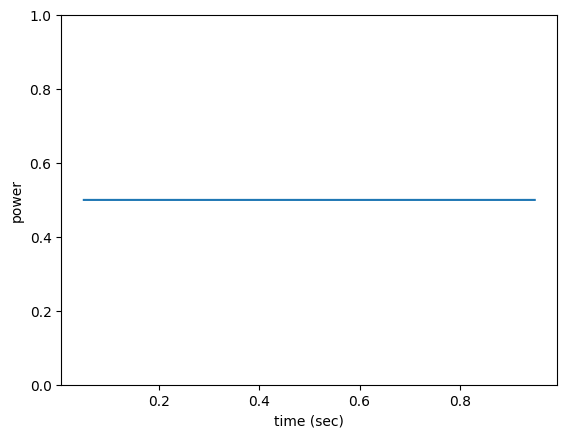

In [7]:
plt.plot(stft.times, stft.power())
plt.xlabel('time (sec)')
plt.ylabel('power')
plt.ylim(0,1)
plt.show()

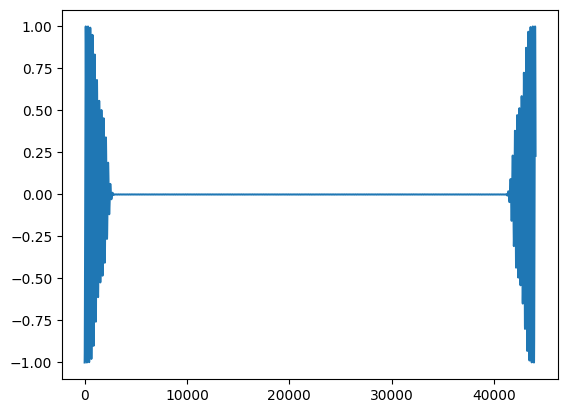

In [8]:
rec_data = stft.synthetize()
plt.plot(rec_data - data[:len(rec_data)])
plt.show()


In [59]:
data, sample_rate = sf.read("output_audio.wav")
data = np.sum(data, axis=1)

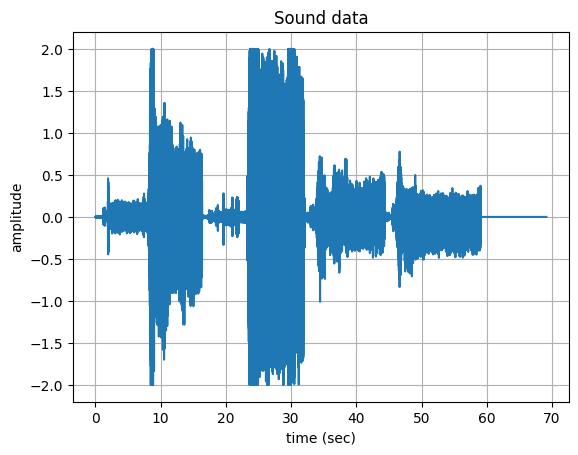

In [60]:
sound.set(data)
fig, ax = sound.plot()
ax.set_xlabel("time (sec)")
ax.set_ylabel("amplitude")
ax.set_title("Sound data")
ax.grid(True)
plt.show()

In [11]:
stft(data)

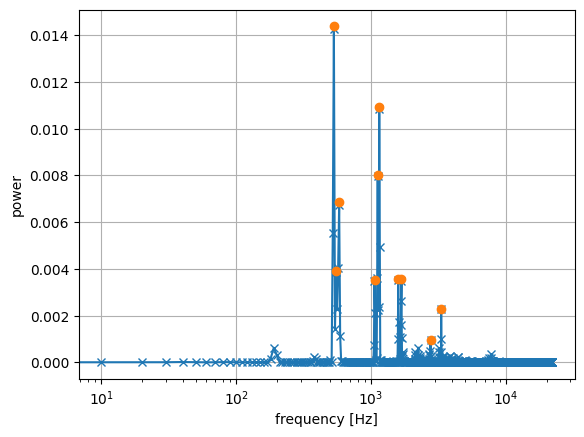

In [12]:
t = 10 #sec
fig, ax = stft.plot_spectrum(t, 'x-', view='power')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('power')
ax.grid(True)

n_time = int((t-stft.times[0])/stft.t_step)
sp_data = data_view(stft.data[n_time], 'power')[:-1]
max_positions, max_values = find_maxima(sp_data, xrange=stft.frequencies, nmax=10)
ax.plot(max_positions,max_values,'o')

plt.show()

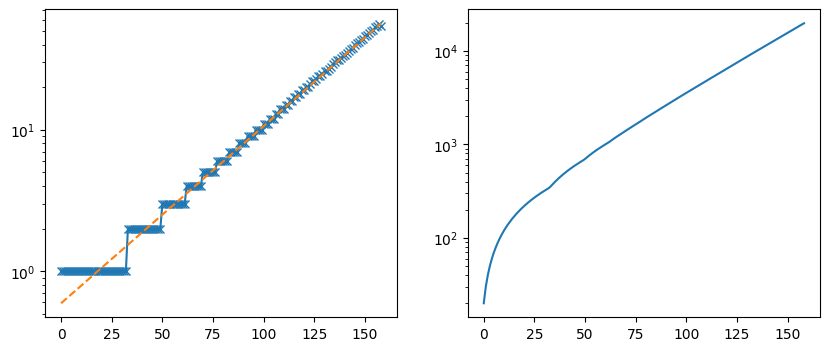

In [13]:
numin = 20 #Hz
numax = 20000 #Hz
N_octave = 24

lf = []
for i,nu in enumerate(stft.frequencies):
    nu = stft.frequencies[i]
    if nu<numin or nu>numax:
        continue
    try:
        if np.log2(nu/stft.frequencies[lf[-1][0]])*N_octave <1:
            lf[-1].append(i)
        else:
            lf.append([i])
    except:
        lf.append([i])
lflen = [len(li) for li in lf]
lfmean =  np.array([np.mean(stft.frequencies[li]) for li in lf])
lf_matrix = np.zeros(shape=(len(lf), len(stft.frequencies)))
for i,lfi in enumerate(lf):
    for lfij in lfi:
        lf_matrix[i,int(lfij)] = 1

ncols=2
fig,ax = plt.subplots(ncols=ncols, figsize=(5*ncols, 4))
ax[0].plot(lflen,'x-')
fr_range = np.arange(len(lf))
ax[0].plot(1.05*lflen[-1]* 2**(-fr_range[::-1]/N_octave),'--')
ax[0].set_yscale('log')

ax[1].plot(lfmean)
ax[1].set_yscale('log')

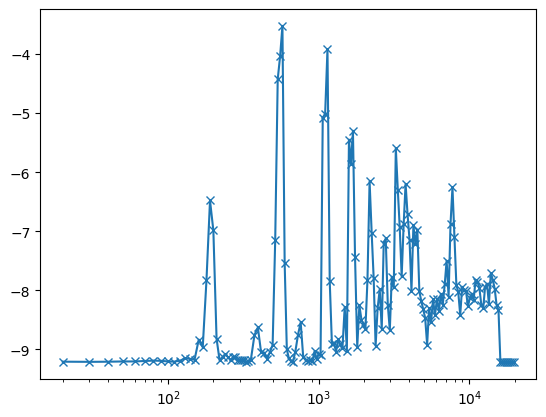

In [14]:
t=10.2 #sec
n_time = int((t-stft.times[0])/stft.t_step)
log_power_spectrum = data_view(stft.data, 'power')@lf_matrix.T
plt.plot(lfmean, np.log(log_power_spectrum[n_time]+1e-4),'x-')
plt.xscale('log')

In [15]:
normed_specrogram = np.array([ fi/(np.max(fi)+1e-4) for fi in log_power_spectrum])
normed_specrogram.shape

(2763, 159)

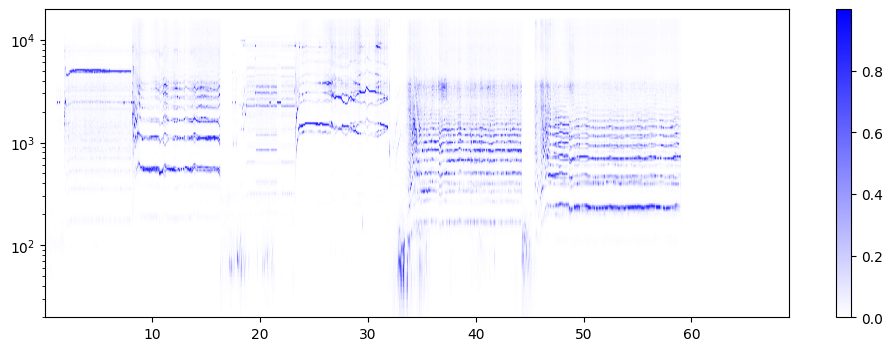

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
colors = ["white", "blue"]  # White for negative, black for positive
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
X, Y = np.meshgrid(stft.times, lfmean, indexing="ij")
#norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.01*log_power_spectrum.max(), vmax=log_power_spectrum.max())
mesh = ax.pcolormesh(X,Y, normed_specrogram, shading='gouraud', cmap=cmap)
ax.set_yscale('log')
fig.colorbar(mesh, ax=ax)

In [17]:
maximum_data = [ [stft.times[i], np.array(find_maxima(nsp, xrange=lfmean, nmax=10)).T] for i,nsp in enumerate(normed_specrogram)]

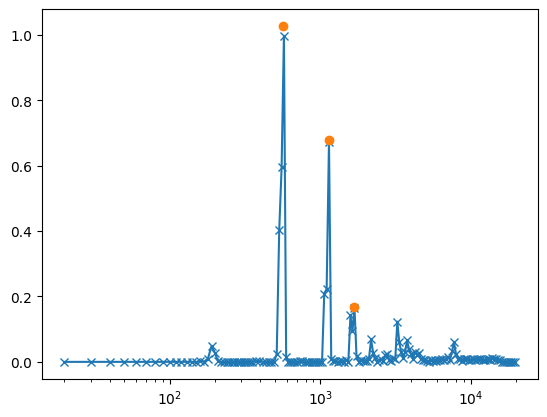

In [38]:
t=10.2 #sec
n_time = int((t-stft.times[0])/stft.t_step)
plt.plot(lfmean, normed_specrogram[n_time],'x-')
U = maximum_data[n_time][1].T
plt.plot(U[0],U[1],'o')
plt.xscale('log')

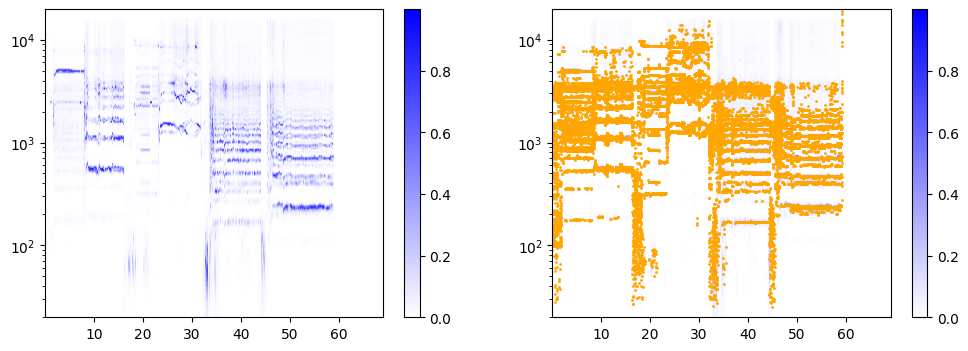

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
colors = ["white", "blue"]  # White for negative, black for positive
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
tt = stft.times[:len(normed_specrogram)]
X, Y = np.meshgrid(tt, lfmean, indexing="ij")
#norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.01*log_power_spectrum.max(), vmax=log_power_spectrum.max())
mesh = ax[0].pcolormesh(X,Y, normed_specrogram, shading='gouraud', cmap=cmap)
ax[0].set_yscale('log')
fig.colorbar(mesh, ax=ax[0])

mesh = ax[1].pcolormesh(X,Y, normed_specrogram, shading='gouraud', cmap=cmap)
for md in maximum_data:
    actual_time = md[0]
    U = md[1].T
    ax[1].plot(actual_time*np.ones(U[0].shape), U[0], 'o', ms=1, color='orange')
ax[1].set_yscale('log')
fig.colorbar(mesh, ax=ax[1])




In [75]:
maximum_data = [ [stft.times[i], np.array(find_maxima(nsp, xrange=lfmean, nmax=3)).T] for i,nsp in enumerate(normed_specrogram)]

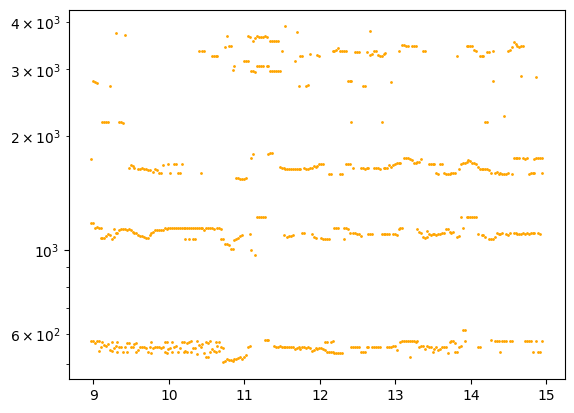

In [76]:
t1= 9 #stft.times[0]
t2= 15
n_time1 = int((t1-stft.times[0])/stft.t_step)
n_time2 = int((t2-stft.times[0])/stft.t_step)
for md in maximum_data[n_time1:n_time2]:
    actual_time = md[0]
    U = md[1].T
    plt.plot(actual_time*np.ones(U[0].shape), U[0], 'o', ms=1, color='orange')
plt.yscale('log')
plt.show()
sound.play(t1,t2)


In [111]:
dominant_peaks = 3
available_peaks = 10
maximum_data = [ [stft.times[i], np.array(find_maxima(nsp, xrange=lfmean, nmax=available_peaks)).T] for i,nsp in enumerate(normed_specrogram)]

In [182]:
tolerance = 0.05
fading_time = 0.5 #sec -- the time after that we forget aabout the track
mydata = maximum_data[n_time1:n_time2]
tracker = []
archived_tracks = []

for dd in mydata:
    trtime = dd[0]
    newdata = dd[1][:,0]
    potential_tracks = newdata[:dominant_peaks]

    archived_tracks.extend([ track for track in tracker if np.abs(trtime-track[-1][0])>=fading_time ])
    tracker = [ track for track in tracker if np.abs(trtime-track[-1][0])<fading_time ]

    for track in tracker:
        tracktime, trackval = track[-1]
        conditions = np.array([ np.abs(nu - trackval)/trackval<tolerance for nu in newdata])
        if len(conditions)>0:
            fitting_freqs = newdata[conditions]
            newdata = newdata[~conditions]
            if len(fitting_freqs)>0:
                track.append( (trtime, np.mean(fitting_freqs)) )

        conditions = np.array([ np.abs(nu - trackval)/trackval<tolerance for nu in potential_tracks])
        if len(conditions>0):
            potential_tracks = potential_tracks[~conditions]

    for p_track in potential_tracks:
        tracker.append( [ (float(trtime), float(p_track)) ] )
for tr in tracker: print(tr)


[(8.970952380952381, 575.0026853902737), (np.float64(8.995941043083901), np.float64(573.7144397172642)), (np.float64(9.02092970521542), np.float64(567.9120762689456)), (np.float64(9.045918367346939), np.float64(574.2268169863918)), (np.float64(9.070907029478459), np.float64(573.7583703751066)), (np.float64(9.095895691609977), np.float64(553.2118824010869)), (np.float64(9.120884353741497), np.float64(570.8592491004347)), (np.float64(9.145873015873017), np.float64(559.048715632706)), (np.float64(9.170861678004535), np.float64(555.7650282296596)), (np.float64(9.195850340136055), np.float64(565.0509299842219)), (np.float64(9.220839002267574), np.float64(543.1973076002563)), (np.float64(9.245827664399092), np.float64(539.7936152774251)), (np.float64(9.270816326530612), np.float64(550.6359145583369)), (np.float64(9.295804988662132), np.float64(558.074814941769)), (np.float64(9.32079365079365), np.float64(553.9249771404859)), (np.float64(9.34578231292517), np.float64(554.9599777248548)), (np.

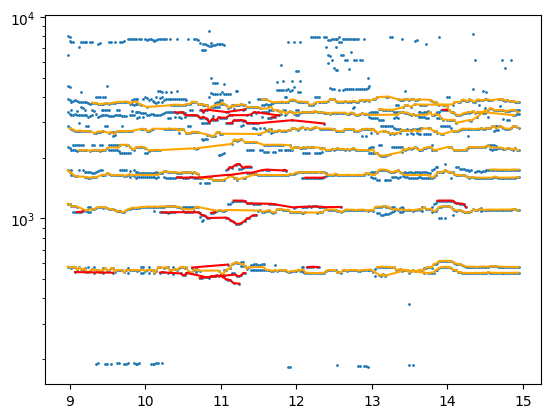

In [184]:
for md in mydata:
    actual_time = md[0]
    U = md[1].T
    plt.plot(actual_time*np.ones(U[0].shape), U[0], 'o', ms=1, color='tab:blue')
plt.yscale('log')

for tr in tracker:
    plt.plot(*np.array(tr).T, color='orange')
for tr in archived_tracks:
    plt.plot(*np.array(tr).T, color='red')
plt.show()